In [55]:
!unzip Dataset.zip

Archive:  Dataset.zip
replace Dataset/bird/image_101.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Imports

In [154]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.utils import shuffle


In [153]:
root_dir = os.path.abspath('Dataset')
target_size = (224, 224)

def load_images_from_directory(root_dir, target_size):
    images = []
    labels = []
    class_indices = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir)))}

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):
            for image_filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, image_filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()
                        img = Image.open(file_path)
                        img = img.resize(target_size, Image.ANTIALIAS)
                        img = img.convert("RGB")  # Ensure 3 channels
                        image_data = np.array(img)

                        images.append(image_data)
                        labels.append(class_indices[folder])
                except (IOError, SyntaxError):
                    pass

    return np.array(images), np.array(labels), class_indices


In [155]:
np.random.seed(42)
tf.random.set_seed(42)

In [156]:
#  input to vgg16 is 224x224 with rgb, batch_size=32
HEIGHT=224
WIDTH=224
BATCH_SIZE=32

In [157]:
# rescale pixel value [0,1]
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# for an augmentation we can use
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    zoom_range=0.1,
#                                    rotation_range=20,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    horizontal_flip = True)

One of "categorical", "binary", "sparse", "input", or None. Determines the type of label arrays that are returned:
- "categorical" will be 2D one-hot encoded labels,
- "binary" will be 1D binary labels,
- "sparse" will be 1D integer labels,
- "input" will be images identical to input images (mainly used to work with autoencoders).

If None, no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict_generator()). Please note that in case of class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly. Defaults to "categorical".

In [158]:
batch_size = 32

images, labels, class_indices = load_images_from_directory(root_dir, target_size)

images, labels = shuffle(images, labels, random_state=42)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)

print("Class indices:", class_indices)

<ipython-input-153-5f602aeff4b1>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


Class indices: {'Persons': 0, 'base ball bat': 1, 'bird': 2, 'cats': 3, 'dog': 4, 'gun': 5, 'hammer': 6, 'knife': 7}


In [159]:
len(labels)

1699

## Display Images

In [160]:
images, labels = next(train_generator)

In [161]:
# per batch
labels.shape

(32,)

In [162]:
def plot_images(images_arr, labels_arr, class_indices):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = list(class_indices.keys())[list(class_indices.values()).index(int(lbl))]
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

In [163]:
labels[:5]

array([5, 3, 4, 5, 1])

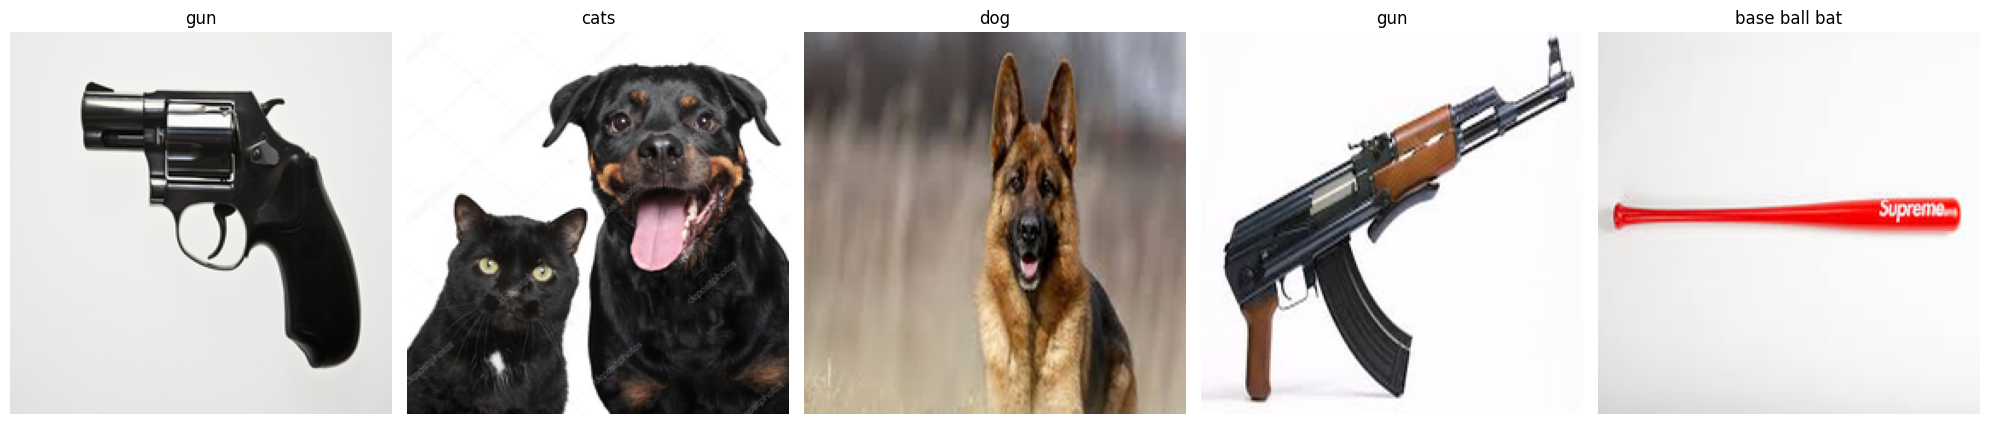

In [164]:
# Display first 5 images from the batch
plot_images(images[:5], labels[:5], class_indices)

# Implementing VGG16 - Transfer Learning

- For binary: sigmoid in last layer
- For multiclass: softmax in last layer

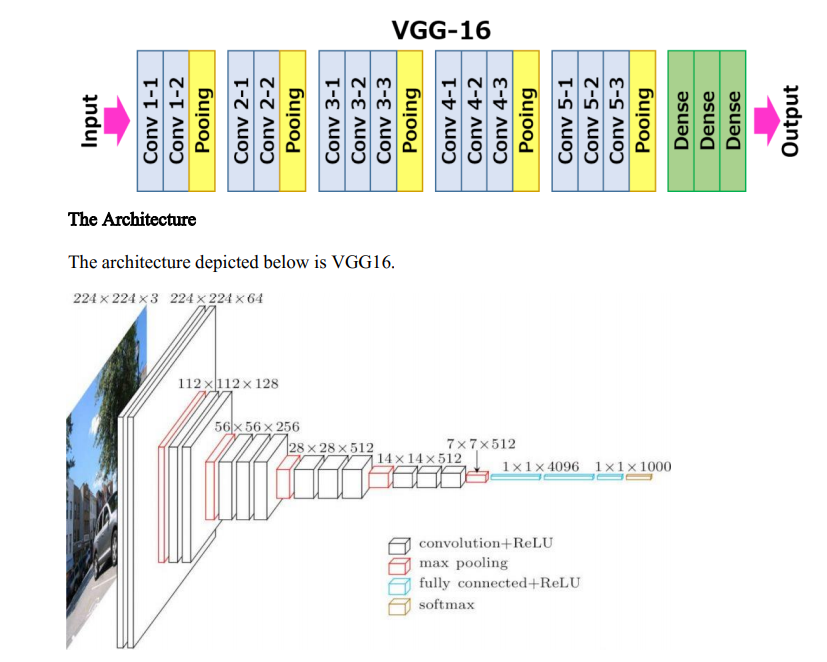

In [165]:
tf.keras.backend.clear_session()

In [166]:
# Loading VGG16 Model with Pre-trained Weights - without final (top) later as we will customize it
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(HEIGHT, WIDTH, 3))

In [167]:
# Freeze the layers of the base model
# so that ony final layer learns from new dataset
for layer in base_model.layers:
    layer.trainable = False

In [168]:
num_classes = len(class_indices)
print('Number of classes:', num_classes)

Number of classes: 8


In [169]:
# 3. Fine-tune the Model
model = Sequential()
model.add(base_model)
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

#
model.add(Dense(num_classes, activation='softmax'))


In [170]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

- SparseCategoricalCrossentropy: This loss function is used when the target labels are integers, e.g., [0, 2, 1, ...] where each integer corresponds to a class. So, if you have 3 classes, the labels would be 0, 1, or 2.
- CategoricalCrossentropy: This loss function is used when the target labels are one-hot encoded, e.g., for three classes, the labels would look like: [[1, 0, 0], [0, 0, 1], [0, 1, 0], ...]

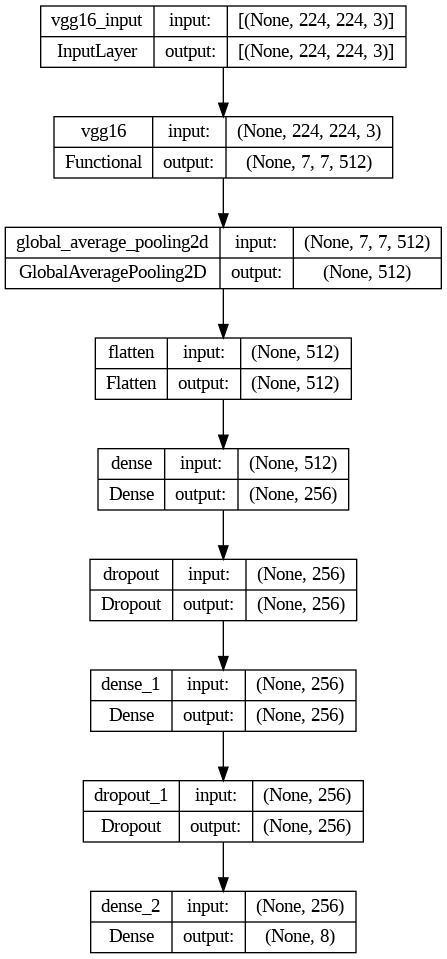

In [171]:
tf.keras.utils.plot_model(model, to_file='vgg16-image-classifier.png', show_shapes=True, show_layer_names=True)

In [172]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

## Adding Callbacks

In [174]:
checkpoint = ModelCheckpoint('vgg16_best_weights.h5',
                             monitor='val_accuracy',
                            #  monitor='val_f1_score',
                             verbose=1,
                             mode='max',
                             save_best_only=True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=5)

callbacks_list = [checkpoint,early]

## Training model
Model weights will be saved to a file called `vgg16_best_weights.h5` whenever there is an improvement in validation accuracy.
After training we can load these weights back into model using `model.load_weights('vgg16_best_weights.h5')`

In [175]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[callbacks_list],
    verbose=True,
    shuffle=True)

Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.7912 - accuracy: 0.3613
Epoch 1: val_accuracy improved from -inf to 0.63529, saving model to vgg16_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 10s 203ms/step - loss: 1.7912 - accuracy: 0.3613 - val_loss: 1.2107 - val_accuracy: 0.6353
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 1.1259 - accuracy: 0.5953
Epoch 2: val_accuracy improved from 0.63529 to 0.83824, saving model to vgg16_best_weights.h5
43/43 [==============================] - 7s 166ms/step - loss: 1.1259 - accuracy: 0.5953 - val_loss: 0.6674 - val_accuracy: 0.8382
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.7827 - accuracy: 0.7145
Epoch 3: val_accuracy improved from 0.83824 to 0.84706, saving model to vgg16_best_weights.h5
43/43 [==============================] - 7s 168ms/step - loss: 0.7827 - accuracy: 0.7145 - val_loss: 0.4568 - val_accuracy: 0.8471
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss: 0.6305 - accuracy: 0.7815
Epoch 4: val_accuracy improved from 0.84706 to 0.90000, saving model to vgg16_best_weights.h5
43/43 [==============================] - 8

In [176]:
model.save('vgg16_complete_model.h5')

## Plotting the results

In [177]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

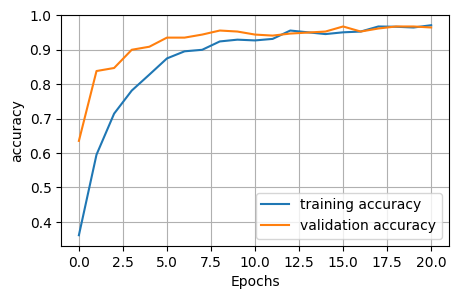

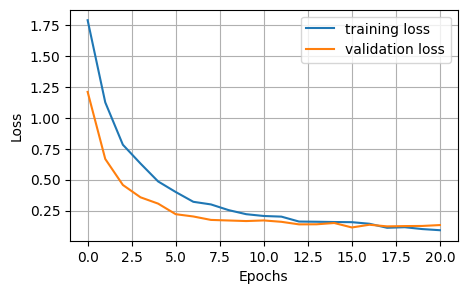

In [178]:
plot_learning_curve(history, metrics='accuracy')

## Evaluate Model

In [179]:
train_result = model.evaluate(train_generator)
test_result = model.evaluate(test_generator)

11/11 [==============================] - 1s 127ms/step - loss: 0.1128 - accuracy: 0.9676


In [180]:
print(f"Train Loss: {np.round(train_result[0], 4)}")
print(f"Test Loss: {np.round(test_result[0], 4)}")
print(f"Train Accuracy: {np.round(train_result[1], 3)}")
print(f"Test Accuracy: {np.round(test_result[1], 3)}")

Train Loss: 0.0566
Test Loss: 0.1128
Train Accuracy: 0.987
Test Accuracy: 0.968


In [181]:
y_pred_probs = model.predict(test_images)
print(y_pred_probs.shape)

11/11 [==============================] - 1s 123ms/step
(340, 8)


In [183]:
# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Get true labels for the test set
true_labels = test_labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[92  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0 17  0]
 [ 0  0 34  0  0  0  0  0]
 [ 0  0  0 52  2  0  0  0]
 [ 0  0  0  4 43  0  0  0]
 [ 0  0  0  0  0 45  2  0]
 [ 0  0  0  0  0  0 21  0]
 [ 0  1  0  0  0  0 16  8]]


In [184]:
precisions = []
recalls = []
f1_scores = []

for i in range(conf_matrix.shape[0]):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Print precision, recall, and F1-score for each class
for i, (precision, recall, f1_score) in enumerate(zip(precisions, recalls, f1_scores)):
    print(f"Class {i}: Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1_score:.4f}")


Class 0: Precision=1.0000, Recall=1.0000, F1-score=1.0000
Class 1: Precision=0.7500, Recall=0.1500, F1-score=0.2500
Class 2: Precision=1.0000, Recall=1.0000, F1-score=1.0000
Class 3: Precision=0.9286, Recall=0.9630, F1-score=0.9455
Class 4: Precision=0.9556, Recall=0.9149, F1-score=0.9348
Class 5: Precision=1.0000, Recall=0.9574, F1-score=0.9783
Class 6: Precision=0.3750, Recall=1.0000, F1-score=0.5455
Class 7: Precision=1.0000, Recall=0.3200, F1-score=0.4848


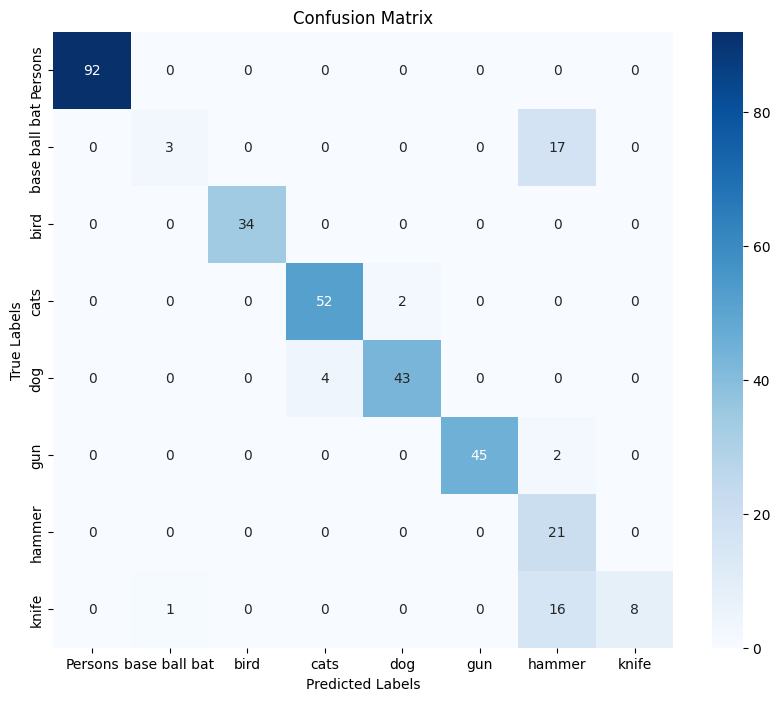

In [186]:
class_labels = ['Persons', 'base ball bat', 'bird', 'cats', 'dog', 'gun', 'hammer', 'knife']

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()